In [1]:
%pylab inline
import tensorflow as tf

Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 30 days


Populating the interactive namespace from numpy and matplotlib


In [2]:
from fuel import config
config.data_path = ['../datasets']

In [3]:
from fuel.datasets.cifar10 import CIFAR10
from fuel.transformers import ScaleAndShift, Cast, Flatten, Mapping
from fuel.streams import DataStream
from fuel.schemes import SequentialScheme, ShuffledScheme

def vectorize_result(Y, classes):
    if Y.shape[1] != 1:
        return Y
    Y = Y.ravel()
    n = Y.shape[0]
    result = np.zeros((n, classes), dtype='float32')
    result[np.arange(n), Y] = 1.0
    return result

CIFAR10.default_transformers = (
    (ScaleAndShift, [2.0 / 255.0, -1], {'which_sources': 'features'}),
    (Cast, [np.float32], {'which_sources': 'features'}), 
    (Flatten, [], {'which_sources': 'features'}),
    (Mapping, [lambda batch: (vectorize_result(b, 10) for b in batch)], {}))
cifar_train = CIFAR10(("train",), subset=slice(None,45000))
cifar_train_stream = DataStream.default_stream(
    cifar_train,
    iteration_scheme=ShuffledScheme(cifar_train.num_examples, 100))

cifar_validation = CIFAR10(("train",), subset=slice(45000, None))

cifar_validation_stream = DataStream.default_stream(
    cifar_validation, iteration_scheme=SequentialScheme(cifar_validation.num_examples, 250))
cifar_test = CIFAR10(("test",))
cifar_test_stream = DataStream.default_stream(
    cifar_test, iteration_scheme=SequentialScheme(cifar_test.num_examples, 250))

In [4]:
print "The streams return batches containing %s" % (cifar_train_stream.sources,)

print "Each trainin batch consits of a tuple containing:"
for element in next(cifar_train_stream.get_epoch_iterator()):
    print " - an array of size %s containing %s" % (element.shape, element.dtype)
    
print "Validation/test batches consits of tuples containing:"
for element in next(cifar_test_stream.get_epoch_iterator()):
    print " - an array of size %s containing %s" % (element.shape, element.dtype)

The streams return batches containing (u'features', u'targets')
Each trainin batch consits of a tuple containing:
 - an array of size (100, 3072) containing float32
 - an array of size (100, 10) containing float32
Validation/test batches consits of tuples containing:
 - an array of size (250, 3072) containing float32
 - an array of size (250, 10) containing float32


In [5]:
sess = tf.InteractiveSession()

In [6]:
x = tf.placeholder(tf.float32, shape=[None, 32*32*3])
y = tf.placeholder(tf.float32, shape=[None, 10])
training = tf.placeholder(tf.bool, shape=())
transform_k = tf.placeholder(tf.float32, shape=())

In [7]:
out = tf.reshape(x, [-1, 3, 32, 32])
out = tf.transpose(out, [0, 2, 3, 1])
transform = tf.random_uniform((8,), -transform_k, transform_k, dtype='float32') \
                        * tf.constant([1, 1, 32, 1, 1, 32, 0, 0], dtype='float32') \
                        + tf.constant([1, 0, 0, 0, 1, 0, 0, 0], dtype='float32')
translation = tf.constant([1, 0, 16, 0, 1, 16, 0, 0], dtype='float32')
translation_back = tf.constant([1, 0, -16, 0, 1, -16, 0, 0], dtype='float32')
transform = tf.contrib.image.compose_transforms(translation, transform, translation_back)
out = tf.contrib.image.transform(out, transform)
input_image = out[:,2:30,2:30,:]
out = tf.contrib.layers.batch_norm(input_image)
out = tf.layers.conv2d(out, 50, (5, 5), activation=tf.nn.relu, padding='same')
out = tf.layers.max_pooling2d(out, (3, 3), strides=2, padding='same')
out = tf.contrib.layers.batch_norm(out)
out = tf.layers.conv2d(out, 70, (5, 5), activation=tf.nn.relu, padding='same')
out = tf.layers.max_pooling2d(out, (3, 3), strides=2, padding='same')
out = tf.layers.dropout(out, 0.3, training=training)
out = tf.contrib.layers.batch_norm(out)
out = tf.reshape(out, [-1, 7 * 7 * 70])
out = tf.layers.dense(out, 300, activation=tf.nn.relu)
out = tf.layers.dropout(out, 0.4, training=training)
out = tf.contrib.layers.batch_norm(out)
out = tf.layers.dense(out, 100, activation=tf.nn.relu)
out = tf.layers.dropout(out, 0.5, training=training)
out = tf.contrib.layers.batch_norm(out)
out = tf.layers.dense(out, 10)

cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=out))

In [8]:
train_op = tf.train.AdamOptimizer().minimize(cross_entropy)

In [9]:
initialize_op = tf.global_variables_initializer()
sess.run(initialize_op)

In [10]:
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(out,1))
correct_sum = tf.reduce_sum(tf.cast(correct_prediction, tf.float32))

def test_accuracy(stream):
    n = 0
    s = 0
    for X, Y in stream.get_epoch_iterator():
        n += X.shape[0]
        s += sess.run(correct_sum, feed_dict={x: X, y: Y, training: False, transform_k: 0})
    return s / n * 100

In [13]:
for i in range(70):
    step = 100
    errors = []
    accuracy = []
    for j, (X, Y) in enumerate(cifar_train_stream.get_epoch_iterator()):
        result = sess.run([train_op, cross_entropy, correct_sum],
                          feed_dict={x: X, y: Y, training: True, transform_k: 0.12})
        errors.append(result[1])
        accuracy.append(result[2] / X.shape[0] * 100)
        if (j + 1) % step == 0:
            print 'Error:', np.mean(errors), 'Accuracy:', np.mean(accuracy)
            errors = []
            accuracy = []
    print 'Epoch', i, '->', 'valid accuracy:', test_accuracy(cifar_validation_stream)

Error: 2.22353 Accuracy: 25.17
Error: 1.81492 Accuracy: 34.82
Error: 1.67038 Accuracy: 39.68
Error: 1.59125 Accuracy: 42.8
Epoch 0 -> valid accuracy: 56.32
Error: 1.45316 Accuracy: 47.37
Error: 1.42001 Accuracy: 49.09
Error: 1.36548 Accuracy: 50.48
Error: 1.318 Accuracy: 52.86
Epoch 1 -> valid accuracy: 63.7
Error: 1.25781 Accuracy: 55.56
Error: 1.26568 Accuracy: 55.04
Error: 1.21577 Accuracy: 57.23
Error: 1.20866 Accuracy: 57.64
Epoch 2 -> valid accuracy: 67.88
Error: 1.1703 Accuracy: 59.44
Error: 1.14275 Accuracy: 60.71
Error: 1.15947 Accuracy: 59.84
Error: 1.15563 Accuracy: 60.66
Epoch 3 -> valid accuracy: 70.48
Error: 1.12211 Accuracy: 61.53
Error: 1.06152 Accuracy: 63.3
Error: 1.08934 Accuracy: 62.66
Error: 1.08979 Accuracy: 62.17
Epoch 4 -> valid accuracy: 73.24
Error: 1.05025 Accuracy: 63.89
Error: 1.04782 Accuracy: 63.91
Error: 1.02506 Accuracy: 64.52
Error: 1.02947 Accuracy: 64.91
Epoch 5 -> valid accuracy: 74.84
Error: 1.00695 Accuracy: 65.88
Error: 1.0197 Accuracy: 64.89
Err

KeyboardInterrupt: 

In [14]:
print 'test accuracy:', test_accuracy(cifar_test_stream)

test accuracy: 80.71


In [15]:
saver = tf.train.Saver()

In [16]:
save_path = saver.save(sess, "model.ckpt")
print 'model saved in', save_path

model saved in model.ckpt


In [17]:
temperature = tf.placeholder(tf.float32, shape=())
softmax = tf.nn.softmax(out / temperature)

In [25]:
small_x = tf.placeholder(tf.float32, shape=[None, 28, 28, 3])
small = tf.contrib.layers.batch_norm(small_x)
small = tf.layers.conv2d(small, 30, (5, 5), activation=tf.nn.relu, padding='same')
small = tf.layers.max_pooling2d(small, (3, 3), strides=2, padding='same')
small = tf.contrib.layers.batch_norm(small)
small = tf.layers.conv2d(small, 40, (5, 5), activation=tf.nn.relu, padding='same')
small = tf.layers.max_pooling2d(small, (3, 3), strides=2, padding='same')
small = tf.contrib.layers.batch_norm(small)
small = tf.reshape(small, [-1, 7 * 7 * 40])
small = tf.layers.dense(small, 100, activation=tf.nn.relu)
small = tf.contrib.layers.batch_norm(small)
small = tf.layers.dense(small, 50, activation=tf.nn.relu)
small = tf.contrib.layers.batch_norm(small)
small = tf.layers.dense(small, 10)

small_cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=small/temperature))

In [26]:
small_train_op = tf.train.AdamOptimizer().minimize(small_cross_entropy)

In [34]:
initialize_op = tf.global_variables_initializer()
sess.run(initialize_op)
saver.restore(sess, "model.ckpt")
print test_accuracy(cifar_test_stream)

INFO:tensorflow:Restoring parameters from model.ckpt
80.71


In [31]:
small_correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(small,1))
small_correct_sum = tf.reduce_sum(tf.cast(small_correct_prediction, tf.float32))

def small_test_accuracy(stream):
    n = 0
    s = 0
    for X, Y in stream.get_epoch_iterator():
        n += X.shape[0]
        inpt = sess.run(input_image, feed_dict={x: X, transform_k: 0})
        s += sess.run(small_correct_sum, feed_dict={small_x: inpt, y: Y})
    return s / n * 100

In [35]:
for i in range(70):
    step = 100
    errors = []
    accuracy = []
    temp = 5
    for j, (X, Y) in enumerate(cifar_train_stream.get_epoch_iterator()):
        [labels, inpt] = sess.run([softmax, input_image], feed_dict={x: X, y: Y, training: False,
                                                                     transform_k: 0.6, temperature: temp})
        result = sess.run([small_train_op, small_cross_entropy, small_correct_sum],
                          feed_dict={small_x: inpt, y: labels, temperature: temp})
        errors.append(result[1])
        accuracy.append(result[2] / X.shape[0] * 100)
        if (j + 1) % step == 0:
            print 'Error:', np.mean(errors), 'Accuracy:', np.mean(accuracy)
            errors = []
            accuracy = []
    print 'Epoch', i, '->', 'valid accuracy:', small_test_accuracy(cifar_validation_stream)

Error: 2.18875 Accuracy: 29.86
Error: 2.13001 Accuracy: 35.33
Error: 2.10349 Accuracy: 38.73
Error: 2.08802 Accuracy: 41.79
Epoch 0 -> valid accuracy: 50.72
Error: 2.07362 Accuracy: 42.98
Error: 2.0686 Accuracy: 44.38
Error: 2.07306 Accuracy: 44.59
Error: 2.05915 Accuracy: 45.2
Epoch 1 -> valid accuracy: 55.26
Error: 2.0502 Accuracy: 46.59
Error: 2.04466 Accuracy: 47.19
Error: 2.05079 Accuracy: 46.4
Error: 2.03515 Accuracy: 48.9
Epoch 2 -> valid accuracy: 59.92
Error: 2.02933 Accuracy: 49.38
Error: 2.01699 Accuracy: 51.25
Error: 2.03462 Accuracy: 50.33
Error: 2.03016 Accuracy: 50.95
Epoch 3 -> valid accuracy: 63.08
Error: 2.01837 Accuracy: 51.36
Error: 2.02848 Accuracy: 51.47
Error: 2.02772 Accuracy: 49.69
Error: 2.01401 Accuracy: 52.32
Epoch 4 -> valid accuracy: 64.58
Error: 2.02012 Accuracy: 51.7
Error: 2.01938 Accuracy: 52.37
Error: 2.02107 Accuracy: 51.74
Error: 2.01207 Accuracy: 53.0
Epoch 5 -> valid accuracy: 65.8
Error: 2.00518 Accuracy: 53.3
Error: 2.01503 Accuracy: 52.98
Error

In [37]:
for i in range(70):
    step = 100
    errors = []
    accuracy = []
    temp = 5
    for j, (X, Y) in enumerate(cifar_train_stream.get_epoch_iterator()):
        [labels, inpt] = sess.run([softmax, input_image], feed_dict={x: X, y: Y, training: False,
                                                                     transform_k: 0.6, temperature: temp})
        result = sess.run([small_train_op, small_cross_entropy, small_correct_sum],
                          feed_dict={small_x: inpt, y: labels, temperature: temp})
        errors.append(result[1])
        accuracy.append(result[2] / X.shape[0] * 100)
        if (j + 1) % step == 0:
            print 'Error:', np.mean(errors), 'Accuracy:', np.mean(accuracy)
            errors = []
            accuracy = []
    print 'Epoch', i, '->', 'valid accuracy:', small_test_accuracy(cifar_validation_stream)

Error: 1.94211 Accuracy: 64.61
Error: 1.9454 Accuracy: 64.93
Error: 1.94788 Accuracy: 63.81
Error: 1.94469 Accuracy: 64.25
Epoch 0 -> valid accuracy: 74.98
Error: 1.95004 Accuracy: 63.89
Error: 1.94541 Accuracy: 64.36
Error: 1.94182 Accuracy: 64.31
Error: 1.94388 Accuracy: 64.67
Epoch 1 -> valid accuracy: 75.18
Error: 1.94476 Accuracy: 64.79
Error: 1.94543 Accuracy: 64.93
Error: 1.94581 Accuracy: 63.72
Error: 1.94903 Accuracy: 63.78
Epoch 2 -> valid accuracy: 75.3
Error: 1.95393 Accuracy: 63.51
Error: 1.94756 Accuracy: 64.47
Error: 1.93804 Accuracy: 65.01
Error: 1.94103 Accuracy: 64.69
Epoch 3 -> valid accuracy: 75.46
Error: 1.95004 Accuracy: 63.86
Error: 1.94258 Accuracy: 64.82
Error: 1.94624 Accuracy: 64.26
Error: 1.9364 Accuracy: 65.53
Epoch 4 -> valid accuracy: 75.34
Error: 1.94709 Accuracy: 64.01
Error: 1.94666 Accuracy: 64.31
Error: 1.94754 Accuracy: 64.23
Error: 1.94632 Accuracy: 63.97
Epoch 5 -> valid accuracy: 75.5
Error: 1.95578 Accuracy: 64.18
Error: 1.93498 Accuracy: 65.51


In [38]:
print 'test accuracy:', small_test_accuracy(cifar_test_stream)

test accuracy: 75.09


In [32]:
for i in range(70):
    step = 100
    errors = []
    accuracy = []
    temp = 5
    for j, (X, Y) in enumerate(cifar_train_stream.get_epoch_iterator()):
        [inpt] = sess.run([input_image], feed_dict={x: X, training: False,
                                                                     transform_k: 0.6, temperature: temp})
        result = sess.run([small_train_op, small_cross_entropy, small_correct_sum],
                          feed_dict={small_x: inpt, y: Y, temperature: temp})
        errors.append(result[1])
        accuracy.append(result[2] / X.shape[0] * 100)
        if (j + 1) % step == 0:
            print 'Error:', np.mean(errors), 'Accuracy:', np.mean(accuracy)
            errors = []
            accuracy = []
    print 'Epoch', i, '->', 'valid accuracy:', small_test_accuracy(cifar_validation_stream)

Error: 2.15589 Accuracy: 20.0
Error: 2.01681 Accuracy: 25.76
Error: 1.97794 Accuracy: 27.56
Error: 1.92869 Accuracy: 29.11
Epoch 0 -> valid accuracy: 37.04
Error: 1.9107 Accuracy: 29.63
Error: 1.86508 Accuracy: 32.29
Error: 1.85671 Accuracy: 31.18
Error: 1.82695 Accuracy: 32.95
Epoch 1 -> valid accuracy: 41.8
Error: 1.82703 Accuracy: 33.21
Error: 1.8156 Accuracy: 33.95
Error: 1.80566 Accuracy: 34.45
Error: 1.78501 Accuracy: 34.72
Epoch 2 -> valid accuracy: 45.18
Error: 1.76159 Accuracy: 35.68
Error: 1.78792 Accuracy: 34.29
Error: 1.7645 Accuracy: 36.1
Error: 1.7794 Accuracy: 34.99
Epoch 3 -> valid accuracy: 46.5
Error: 1.75215 Accuracy: 35.44
Error: 1.73165 Accuracy: 36.07
Error: 1.7067 Accuracy: 38.5
Error: 1.73088 Accuracy: 36.98
Epoch 4 -> valid accuracy: 47.92
Error: 1.72715 Accuracy: 36.51
Error: 1.71878 Accuracy: 37.12
Error: 1.70878 Accuracy: 37.88
Error: 1.70931 Accuracy: 37.83
Epoch 5 -> valid accuracy: 49.72
Error: 1.68136 Accuracy: 38.85
Error: 1.68379 Accuracy: 38.94
Error:

In [33]:
print 'test accuracy:', small_test_accuracy(cifar_test_stream)

test accuracy: 61.91


[  1.65125559e-04   4.91900255e-06   7.25940568e-03   4.97083247e-01
   2.04243930e-03   4.83559519e-01   1.35003997e-03   8.40392243e-03
   3.04801797e-05   1.00820980e-04]
[ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
(250, 3072)


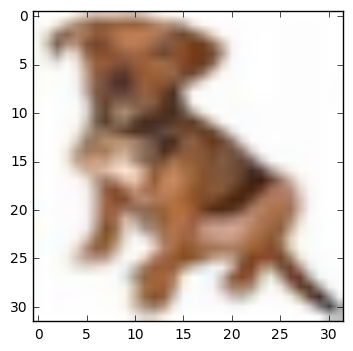

In [61]:
for X, Y in cifar_test_stream.get_epoch_iterator():
    results = sess.run(softmax, feed_dict={x: X, y: Y, training: False, transform_k: 0})
    wrong = np.random.choice(np.nonzero(np.argmax(results, 1) != np.argmax(Y, 1))[0])
    print results[wrong]
    print Y[wrong]
    print X.shape
    imshow(X[wrong].reshape(3, 32, 32).transpose(1, 2, 0) / 2 + 0.5)
    break

In [129]:
softmax = tf.nn.softmax(out)
wrong = []
pred = []
for X, Y in cifar_test_stream.get_epoch_iterator():
    results = sess.run(softmax, feed_dict={x: X, y: Y, training: False, transform_k: 0})
    correct = np.argmax(Y, 1)
    predictions = np.argmax(results, 1)
    wrong += [results[i, predictions[i]] - results[i,correct[i]] for i in range(correct.shape[0]) if correct[i] != predictions[i]]
    pred += list(results.max(axis=1).ravel())

(array([  2.00000000e+00,   2.00000000e+00,   3.00000000e+00,
          5.00000000e+00,   1.20000000e+01,   1.40000000e+01,
          2.80000000e+01,   3.70000000e+01,   5.20000000e+01,
          5.40000000e+01,   8.70000000e+01,   1.14000000e+02,
          1.13000000e+02,   1.20000000e+02,   1.21000000e+02,
          9.80000000e+01,   1.18000000e+02,   1.19000000e+02,
          1.35000000e+02,   1.28000000e+02,   1.22000000e+02,
          1.44000000e+02,   1.38000000e+02,   1.45000000e+02,
          1.94000000e+02,   2.01000000e+02,   2.52000000e+02,
          3.35000000e+02,   5.30000000e+02,   6.57700000e+03]),
 array([ 0.22549804,  0.25131477,  0.2771315 ,  0.30294823,  0.32876496,
         0.3545817 ,  0.38039843,  0.40621516,  0.43203189,  0.45784862,
         0.48366536,  0.50948209,  0.53529882,  0.56111555,  0.58693229,
         0.61274902,  0.63856575,  0.66438248,  0.69019921,  0.71601595,
         0.74183268,  0.76764941,  0.79346614,  0.81928287,  0.84509961,
         0.87

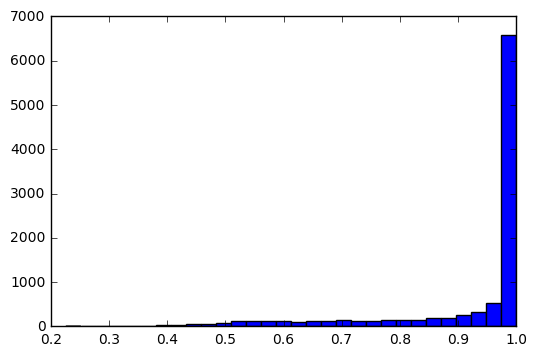

In [130]:
hist(pred, bins=30)